Initial run for Isabel's Data
=================

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
basedir = '../'
sys.path.append(basedir)

import numpy as np
import pandas as pd
import pylab as plt
from IPython.display import display
import math

from lda_for_fragments import Ms2Lda

<h2>Analysis</h2>

<h3>a. Run LDA</h3>

In [2]:
fragment_filename = 'isabelpos_fragments.csv'
neutral_loss_filename = 'isabelpos_losses.csv'
mzdiff_filename = None
ms1_filename = 'isabelpos_ms1.csv'
ms2_filename = 'isabelpos_ms2.csv'
ms2lda = Ms2Lda.lcms_data_from_R(fragment_filename, neutral_loss_filename, mzdiff_filename, 
                             ms1_filename, ms2_filename)

Loading input files
Data shape (435, 1108)


In [3]:
### all the parameters you need to specify to run LDA ###

n_topics = 100
n_samples = 1000
n_burn = 0 # if 0 then we only use the last sample
n_thin = 1 # every n-th sample to use for averaging after burn-in. Ignored if n_burn = 0
alpha = 50.0/n_topics # hyper-parameter for document-topic distributions
beta = 0.1 # hyper-parameter for topic-word distributions

ms2lda.run_lda(n_topics, n_samples, n_burn, n_thin, alpha, beta)

Fitting model...
CGS LDA initialising
............................................
Using Numba for LDA sampling
Preparing words
Preparing Z matrix
DONE
Sample 1   Log likelihood = -1461466.853 
Sample 2   Log likelihood = -1042352.717 
Sample 3   Log likelihood = -728233.192 
Sample 4   Log likelihood = -615263.063 
Sample 5   Log likelihood = -575765.339 
Sample 6   Log likelihood = -556139.565 
Sample 7   Log likelihood = -544430.841 
Sample 8   Log likelihood = -534607.046 
Sample 9   Log likelihood = -528740.628 
Sample 10   Log likelihood = -522917.197 
Sample 11   Log likelihood = -518421.127 
Sample 12   Log likelihood = -515177.828 
Sample 13   Log likelihood = -513795.819 
Sample 14   Log likelihood = -512253.379 
Sample 15   Log likelihood = -509922.274 
Sample 16   Log likelihood = -507959.845 
Sample 17   Log likelihood = -506629.517 
Sample 18   Log likelihood = -505258.369 
Sample 19   Log likelihood = -503907.724 
Sample 20   Log likelihood = -502951.820 
Sample 21   Log

<h3>b. Annotations</h3>

In [4]:
sirius_platform = 'orbitrap'
ms2lda.annotate_with_sirius(sirius_platform, mode='pos', max_ms1=9999) # mode is either 'pos' or 'neg'

Running SIRIUS annotation with parameters:
- platform = orbitrap
- mode = pos
- ppm_max = 5
- min_score = 0.01
- max_ms1 = 9999

    1/  435 pID  452 m/z 385.18096 int 8.1252e+05 n_frags  5	ACCEPT	3 fragment(s) annotated with score 12.63
    2/  435 pID  631 m/z 513.25313 int 8.3645e+05 n_frags  1	ACCEPT	0 fragment(s) annotated with score 0.20
    3/  435 pID  672 m/z 358.25877 int 6.2059e+05 n_frags  9	ACCEPT	6 fragment(s) annotated with score 21.38
    4/  435 pID  693 m/z 391.25098 int 7.0632e+05 n_frags 13	ACCEPT	10 fragment(s) annotated with score 21.22
    5/  435 pID  701 m/z 763.38784 int 3.0677e+06 n_frags  5	ACCEPT	4 fragment(s) annotated with score 1.63
    6/  435 pID  716 m/z 742.45888 int 1.7964e+06 n_frags  7	ACCEPT	5 fragment(s) annotated with score 9.68
    7/  435 pID  718 m/z 880.59025 int 8.6466e+05 n_frags  5	ACCEPT	5 fragment(s) annotated with score 2.88
    8/  435 pID  723 m/z 312.21684 int 7.1932e+05 n_frags 16	ACCEPT	14 fragment(s) annotated with score 50.33
 

In [5]:
peaklist_filename = 'peaklist_POS.csv'
peaklist = pd.read_csv(peaklist_filename)
annot = peaklist[['mz', 'rt', 'int', 'Metabolite']]
annot = annot[pd.notnull(annot['Metabolite'])] # drop NaN metabolites
# display(annot)

label_len = 20
mass_tol = 10
rt_tol = 120

# for each row in the IDIOM annotation results 
total_match = 0
for row in annot.itertuples():
    
    # get mz, rt, intensity and the putative metabolite identity
    mz = row[1]
    rt = row[2]
    intensity = row[3]
    label = row[4]
    
    # truncate long metabolite names
    label = (label[:label_len] + '..') if len(label) > label_len else label    
    print "Processing " + str((mz, rt, intensity)) + " " + label

    # find matching MS1 within mass_tol and rt_tol
    interval = mz*mass_tol*1e-6
    mass_start, mass_end = (mz-interval, mz+interval)
    rt_start, rt_end = (rt-rt_tol, rt+rt_tol)
    
    match_mass = (ms2lda.ms1.mz>mass_start) & (ms2lda.ms1.mz<mass_end)
    match_rt = (ms2lda.ms1.rt>rt_start) & (ms2lda.ms1.rt<rt_end)
    match = match_mass & match_rt
    
    res = ms2lda.ms1[match]
    if len(res) == 1:

        # if only 1 match, immediately annotate
        print "Found 1 hit"
        idx = res.index[0]
        ms2lda.ms1.loc[[idx], 'annotation'] = label
        display(res)
        total_match += 1

    elif len(res) > 0:

        print "Found %d hits" % len(res)        
        
        # if multiple matches, find the closest in RT   
        closest = None
        min_dist = sys.maxint
        for match_res in res.itertuples():
            match_rt = match_res[4]
            match_mz = match_res[5]
            dist = math.sqrt((match_rt-rt)**2 + (match_mz-mz)**2)
            if dist < min_dist:
                min_dist = dist
                closest = match_res

        idx = closest[0]
        ms2lda.ms1.loc[[idx], 'annotation'] = label
        display(res)
        total_match += 1        
        
    print
    
print "total_match=" + str(total_match) + "/" + str(annot.shape[0])

Processing (74.023649131799999, 695.99287668859995, 3532) Iminoglycine

Processing (74.060028577300002, 595.91434650029998, 48715) Aminoacetone
Found 2 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
3888,3888,0,1,508.189,74.060018,1482000.625,1,20,0,C3H7NO
5502,5502,0,1,615.361,74.060035,4867594.000,1,0,0,C3H7NO



Processing (76.039295691999996, 822.14852842990001, 245819) Glycine

Processing (76.075680390399995, 648.1435085997, 57397) (R)-1-Aminopropan-2-..

Processing (80.933275080399994, 717.23124694820012, 42302) Br-

Processing (80.973440680799996, 761.56412251789993, 50043) Phosphite

Processing (84.968603313199992, 719.78424962359998, 27809) Chlorate

Processing (85.028325006800003, 801.41749318439997, 20889) 3-Butynoate

Processing (85.028426194199994, 649.78524907430005, 8415) 3-Butynoate

Processing (87.043988719699996, 655.28750101730009, 4522) 2-Butenoate

Processing (87.044030326399991, 794.88474655149992, 56969) Diacetyl

Processing (88.039292097299992, 801.01649856570009, 15314) 2-Aminoacrylate

Processing (89.023254566800006, 462.82610321039999, 2810079) Pyruvate

Processing (89.023315023999999, 784.43687184649991, 352474) 3-Oxopropanoate

Processing (90.018562747800004, 729.3231239319, 13831) Oxamate

Processing (90.054894186799999, 791.51574579869998, 10722286) L-Alanine

Proc

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
6525,6525,0,1,646.69,104.070598,11221028,1,0,0,C4H9NO2



Processing (104.10688496629999, 1155.3761260363999, 28949832) Choline

Processing (105.0182358154, 798.06350199380006, 9988) 2-Hydroxy-3-oxopropa..

Processing (105.0295143625, 642.83687464399998, 35344) Urea-1-carboxylate

Processing (105.0546014952, 452.55541356399999, 5750) (R)-3-Hydroxybutanoa..

Processing (106.0498453332, 820.6587524414, 1305799) L-Serine

Processing (106.08618642280001, 653.40012281769998, 3484) Diethanolamine

Processing (107.033812641, 809.7871911881, 11242) L-Glycericacid

Processing (107.0339011241, 663.72237396239996, 268965) D-Glycerate

Processing (110.03622018110001, 451.77791341150004, 15534) Benzosemiquinone

Processing (112.0505110542, 689.40832644089994, 17180) Cytosine

Processing (112.99990653340001, 749.15387598669997, 12261) Hydroxymethylphospho..

Processing (113.0233355487, 867.20234063329997, 116196) 2-Furoate

Processing (113.03458859120001, 528.21793619790003, 132079) Orotate(Fragment)

Processing (113.0596309583, 247.42152441119998, 5498) 

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
3584,3584,0,1,496.476,114.066183,375707808,1,247,0,C4H7N3O



Processing (115.01394348540001, 726.24999872839999, 8904) parabanate

Processing (115.0389740576, 794.34724680580007, 508504) 2-Hydroxy-2,4-pentad..

Processing (115.05023975379999, 476.25372886660006, 11747) 5,6-Dihydrouracil

Processing (116.0342430086, 434.65248171489998, 38202) Maleamate

Processing (116.07038144319999, 721.79277567960003, 35457812) L-Proline
Found 7 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
6581,6581,0,1,675.195,116.070605,42657660,1,0,0,C5H9NO2
6582,6582,0,1,799.523,116.070604,20779760,1,0,0,C5H9NO2
6583,6583,0,1,645.711,116.070626,52252268,1,0,0,C5H9NO2
6584,6584,0,1,619.300,116.070634,72310528,1,269,0,C5H9NO2
6585,6585,0,1,745.862,116.070609,20780818,1,0,0,C5H9NO2
6586,6586,0,1,713.896,116.070599,26674006,1,0,0,C5H9NO2
6587,6587,0,1,727.950,116.070602,23084028,1,265,0,C5H9NO2



Processing (116.07063312790001, 1224.1820856730001, 62654) D-Proline

Processing (116.0706458719, 1365.0393753052001, 66221) D-Proline

Processing (116.0706620424, 966.7735163991, 19938) 3-acetamidopropanal
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
6580,6580,0,1,900.49,116.07061,14116196,1,0,0,C5H9NO2



Processing (116.10689679079999, 1169.7432711853999, 9144) Trimethylaminoaceton..

Processing (117.05462726409999, 292.13012568160002, 381491) ethylpyruvate

Processing (117.05464576129999, 453.41699790949997, 66694) 3-Methyl-2-oxobutano..

Processing (117.09098722510001, 280.76697731019999, 117499) 4-Hydroxyhexan-3-one

Processing (118.04987209719999, 727.34825134280004, 29622) L-2-Amino-3-oxobutan..

Processing (118.04991036940001, 1357.4043680827001, 26647) L-Aspartate 4-semial..

Processing (118.06106096299999, 835.04537455240006, 10335) Guanidinoacetate

Processing (118.08618253700001, 660.44130660079998, 10669920) L-Valine

Processing (118.0863048802, 1330.0770975749001, 116145) 5-Aminopentanoate

Processing (118.0863075492, 1050.1031114366001, 23430) 4-Methylaminobutyrat..

Processing (118.0863144332, 1131.3297671363, 82157) Betaine

Processing (119.03393695940001, 769.731745402, 4335008) Succinate

Processing (119.0854738803, 249.296264337, 37897) alpha-Methylstyrene

Processin

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
5460,5460,0,1,746.861,120.065537,7492794.0,1,0,0,C4H9NO3
5464,5464,0,1,853.359,120.065547,4348642.5,1,299,0,C4H9NO3
5467,5467,0,1,727.950,120.065534,8346126.0,1,0,0,C4H9NO3



Processing (121.0494638511, 792.95036951700001, 287062) D-Erythrose

Processing (122.02696031309999, 808.34137217199998, 22400) L-Cysteine

Processing (123.0109788794, 725.51837539669998, 42097) 3-Mercaptolactate

Processing (123.05519512299999, 736.52988231429993, 103363) Picolinamide

Processing (123.05524425520001, 452.2896709831, 2703426) Nicotinamide
Found 2 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
2987,2987,0,1,423.639,123.055482,72183136,1,325,0,C6H6N2O
2988,2988,0,1,393.783,123.055315,8091679,1,0,0,C6H6N2O



Processing (124.99037319709998, 639.3308728536, 2715) Sulfoacetaldehyde

Processing (126.0218537561, 790.37787246699997, 98152) Taurine

Processing (126.0549213505, 809.72277458350004, 3826) N-Ethylmaleimide

Processing (127.00594513370001, 620.46399688719998, 6998) 2-Hydroxyethanesulfo..

Processing (127.01561995909999, 752.84487406410005, 4840) 2-Hydroxyethylphosph..

Processing (127.0501896202, 453.04281171160005, 1023040) Thymine

Processing (128.07049944810001, 734.87020811740001, 37646) 2,3,4,5-Tetrahydropy..

Processing (129.0657182615, 453.38633346559999, 8637) 5,6-Dihydrothymine

Processing (130.04987518799999, 596.57795461019998, 4574442) L-1-Pyrroline-3-hydr..
Found 2 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
4051,4051,0,1,588.752,130.049907,8791941,1,0,0,C5H7NO3
5124,5124,0,1,631.032,130.049991,141326192,1,384,0,C5H7NO3



Processing (130.0499200022, 1346.1266632080001, 78629) L-1-Pyrroline-3-hydr..

Processing (130.04992044690002, 727.23800023399997, 365107) 1-Pyrroline-4-hydrox..
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
5124,5124,0,1,631.032,130.049991,141326192,1,384,0,C5H7NO3



Processing (130.08624723329999, 376.550101144, 15640) N4-Acetylaminobutana..
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
2996,2996,0,1,422.672,130.086465,32309230,1,0,0,C6H11NO2



Processing (130.08629517930001, 657.66379593830004, 23063) L-Pipecolate

Processing (131.0702625516, 275.20387776690001, 1445290) Ethyl 3-oxobutanoate

Processing (131.10659184049999, 245.01761331360001, 130670) Ethyl isovalerate
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
1730,1730,0,1,233.054,131.106733,6087012.5,1,0,0,C7H14O2



Processing (131.1178971638, 1008.1326530611999, 836606) N-Acetylputrescine

Processing (132.0654483779, 778.08697758890003, 279470) L-Glutamate 5-semial..

Processing (132.0766321502, 789.35853171839995, 1384626) Creatine

Processing (132.10182465669999, 642.71852828049998, 13927689) L-Leucine
Found 6 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
5469,5469,0,1,536.499,132.101811,779540288,1,0,0,C6H13NO2
5470,5470,0,1,662.381,132.101916,11527977,1,0,0,C6H13NO2
5473,5473,0,1,577.922,132.101847,42287180,1,0,0,C6H13NO2
5474,5474,0,1,596.643,132.101970,22142220,1,0,0,C6H13NO2
5475,5475,0,1,616.326,132.101936,15396839,1,411,0,C6H13NO2
5478,5478,0,1,559.155,132.101890,72350496,1,0,0,C6H13NO2



Processing (132.10185488690001, 824.67204411820012, 223295) L-Isoleucine

Processing (132.10188352349999, 1243.889782964, 259898) (3R)-beta-Leucine

Processing (132.1019192217, 1120.8412501016999, 204356) 6-Aminohexanoate

Processing (133.0495844127, 795.93199666340001, 166889) 2-Acetolactate

Processing (133.0607250864, 797.86412811280002, 1159831) L-Asparagine

Processing (133.0858570085, 288.60604031880001, 90735) [FA hydroxy(6:0)] 4-..

Processing (133.09714529530001, 1096.1304259008, 266030) L-Ornithine

Processing (134.02697955389999, 489.04977226260002, 52082) L-thiazolidine-4-car..

Processing (134.04474422679999, 773.50199762979992, 439978) L-Aspartate

Processing (134.08110410790002, 422.50477568959997, 314766) N-hydroxyvaline
Found 3 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
2998,2998,0,1,422.672,134.081333,117679688,1,0,0,C5H11NO3
3000,3000,0,1,392.789,134.081204,15000716,1,0,0,C5H11NO3
3002,3002,0,1,378.860,134.081253,9669711,1,432,0,C5H11NO3



Processing (135.02876286439999, 804.29762903850008, 3991491) (S)-Malate

Processing (135.0652097565, 513.29727236430006, 25007) Deoxyribose

Processing (135.08033558440002, 253.6355746655, 6187) Phenylacetone

Processing (136.0425844534, 676.04137293500003, 4668) L-Homocysteine

Processing (136.06177500499999, 587.05983687419996, 301251) Adenine
Found 2 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
5489,5489,0,1,644.732,136.061840,4867298.0,1,446,0,C5H5N5
5492,5492,0,1,666.306,136.061808,3771983.5,1,0,0,C5H5N5



Processing (137.0445486591, 684.10749562579997, 469890) [FA trihydroxy(4:0)]..

Processing (137.04576541119999, 617.73146773359997, 2751333) Hypoxanthine
Found 2 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
6781,6781,0,1,513.066,137.045745,843453632,1,453,0,C5H4N4O
6782,6782,0,1,558.177,137.045806,5615710,1,0,0,C5H4N4O



Processing (137.05956549160001, 272.702457428, 22583) 4-Hydroxyphenylaceta..

Processing (137.05963330879999, 787.19825235999997, 15172) Phenylacetic acid

Processing (138.05488972320001, 679.97547009530001, 3364) Anthranilate

Processing (139.00586591530001, 776.12912750240002, 60118) 3-sulfopropanal

Processing (139.04995393839999, 623.65224285509998, 359642) Urocanate
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
3546,3546,0,1,514.031,139.049934,2093933.625,1,0,0,C6H6N2O2



Processing (140.08181452629998, 472.66669261699997, 11476) L-Histidinal

Processing (141.0658302384, 559.36685865749996, 17205) Methylimidazoleaceti..

Processing (141.99013527310001, 1006.1748746236, 84006) Carbamoyl phosphate

Processing (142.0264244974, 806.45612589519999, 7312) Ethanolamine phospha..

Processing (142.0860504812, 723.46800263070008, 11081) L-Hypoglycin

Processing (142.9831182163, 541.08304287520002, 7159) 2-Mercaptoethanesulf..

Processing (143.1066644828, 300.17155114000002, 2360) [FA (8:1)] 2Z-octeno..

Processing (145.04963292799999, 798.45274988810002, 21289) 2,3-Dimethylmaleate

Processing (145.10834457319999, 1257.0224990844999, 2711) 4-Guanidinobutanamid..

Processing (145.12229098520001, 261.69991556799999, 178437) [FA (8:0)] octanoic ..

Processing (145.1334348892, 628.13730792609999, 116311) 1-(3-aminopropyl)-4-..

Processing (146.02694557140001, 451.38308270769994, 27499) 3,4-Dehydrothiomorph..

Processing (146.04472448319999, 609.95877456669996, 31641)

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
4139,4139,0,1,588.752,148.060380,150528768,1,0,0,C5H9NO4
4141,4141,0,1,570.970,148.060411,26098148,1,0,0,C5H9NO4



Processing (148.0966896246, 631.40436787509998, 25202) N-hydroxyisoleucine

Processing (148.09672926370001, 695.90963184589998, 57235) Fagomine

Processing (149.04441961219999, 769.83674875899999, 2377139) D-Xylonolactone

Processing (150.05818877459998, 667.18149820960002, 3163971) L-Methionine
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
5307,5307,0,1,631.996,150.058297,2686114.25,1,0,0,C5H11NO2S



Processing (150.07586920559999, 652.94025039669998, 19145) 4-amino-4-deoxy-L-ar..

Processing (150.11243286530001, 568.71671590999995, 9114) Triethanolamine

Processing (151.05973182370002, 788.90512339270003, 60436) D-Ribose

Processing (151.07526310120002, 277.6776460012, 400709) 4-Coumaryl alcohol

Processing (152.05638087200001, 713.88287480669999, 34664) Guanine

Processing (153.04066139939999, 650.82687377930006, 418707) Xanthine

Processing (153.0757018809, 731.80237706499997, 15409) Xylitol

Processing (155.01035138700001, 644.93374760949996, 81776) Propanoyl phosphate

Processing (155.04505242350001, 604.93577482260002, 56653) Imidazol-5-yl-pyruva..

Processing (155.05638035250001, 507.48475011190004, 5246) 6,8-dihydroxypurine

Processing (156.07664829160001, 780.56314522880007, 2108177) L-Histidine
Found 5 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
5327,5327,0,1,756.901,156.076828,817736.500,1,0,0,C6H9N3O2
5331,5331,0,1,688.010,156.076821,4901455.500,1,0,0,C6H9N3O2
5340,5340,0,1,716.960,156.076813,1379690.750,1,0,0,C6H9N3O2
5341,5341,0,1,727.950,156.076827,1063793.250,1,0,0,C6H9N3O2
5342,5342,0,1,742.888,156.076823,764121.375,1,0,0,C6H9N3O2



Processing (156.10181943840001, 657.9083760579, 8010) Retronecine

Processing (157.02429834309999, 589.07496178669999, 3228) Orotate

Processing (157.0607467239, 632.65175120039999, 88903) 4-Imidazolone-5-prop..

Processing (159.0510245248, 775.80362701419995, 8700) Allantoin

Processing (159.13794942139998, 243.16070842740001, 121282) Nonanoic acid

Processing (160.13344489420001, 735.04034553690008, 13193) DL-2-Aminooctanoicac..

Processing (161.09201346590001, 455.80977521620002, 45132) D-Alanyl-D-alanine

Processing (161.09205372100001, 627.95150248209995, 16147) D-Alanyl-D-alanine
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
5308,5308,0,1,615.361,161.092103,12231641,1,0,0,C6H12N2O3



Processing (161.1283348691, 1137.6683324178, 44037) N6-Methyl-L-lysine

Processing (162.05827380600002, 448.04951922099997, 131100) allylcysteine
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
2759,2759,0,1,344.941,162.058513,1996654,1,0,0,C6H11NO2S



Processing (162.0759845579, 808.31887817380004, 30121) L-2-Aminoadipate

Processing (162.07603853930001, 561.38869094849997, 11535) O-Acetyl-L-homoserin..

Processing (162.0760651411, 714.76975250240002, 8176) N-Methyl-L-glutamate

Processing (162.1123488174, 734.40845349369999, 3979274) L-Carnitine

Processing (163.04228106760002, 468.19970575970001, 3332) 1,2-Dihydroxy-5-(met..

Processing (163.06006519499999, 799.26212310789992, 712623) 2-Dehydro-3-deoxy-L-..

Processing (164.0916879561, 817.00562794999996, 16537) 1-deoxynojirimycin

Processing (165.05456989780001, 273.0294787089, 658095) Phenylpyruvate

Processing (166.07204361540002, 732.55650456750004, 24111) 3-Methylguanine

Processing (166.08623258980001, 614.17138298190002, 1119711) L-Phenylalanine
Found 2 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
5496,5496,0,1,496.476,166.086259,213679056.0,1,0,0,C9H11NO2
5497,5497,0,1,560.162,166.086302,8073328.5,1,0,0,C9H11NO2



Processing (167.0338799294, 742.86612574259993, 13270) Phthalate

Processing (167.05495846139999, 714.32062276199997, 59799) L-Arabinonate

Processing (167.07016386680002, 288.56943639119999, 367476) 3-Methoxy-4-hydroxyp..

Processing (167.0702506671, 425.0669600169, 17012) 3-(3-Hydroxy-phenyl)..

Processing (167.0913993918, 661.97650019330001, 20248) L-rhamnitol

Processing (168.06552327100002, 484.6491612026, 141647) Pyridoxal

Processing (169.03559914389999, 688.61887105309995, 36714) Urate

Processing (169.09709770250001, 675.81305803570001, 19132) Pyridoxamine

Processing (169.1950363816, 223.86697907139998, 7507) 1-Dodecene

Processing (170.05753616819999, 737.88687260949996, 21344) Phosphodimethylethan..

Processing (170.08110681870002, 492.59506287870005, 6387) Pyridoxine

Processing (170.09234349030001, 462.54727045690004, 18639) histidine methyl est..

Processing (170.0923564997, 698.55199941000001, 464676) N(pi)-Methyl-L-histi..

Processing (171.0051996782, 778.199998219799

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
2379,2379,0,1,276.842,176.03785,8410284,1,815,0,C6H9NO3S



Processing (176.03760213830003, 806.28375625609999, 3926) nonulose 9-phosphate

Processing (176.03762885099999, 293.83216603599999, 67997) nonulose 9-phosphate
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
2379,2379,0,1,276.842,176.03785,8410284,1,815,0,nonulose 9-phosphate



Processing (176.10284511270001, 823.35099665320013, 21302) L-Citrulline

Processing (176.10294705650003, 822.11899948119992, 175598) L-Citrulline

Processing (177.03926430589999, 777.50437291460003, 826854) Ascorbate

Processing (177.07565647259997, 716.20874913529997, 4096) (2S)-2-Isopropylmala..

Processing (177.09823874529999, 847.63383639589995, 159118) Canavanine

Processing (178.07088032409999, 706.48474502559998, 356606) 4-Hydroxy-4-methylgl..

Processing (179.05495241610001, 624.43412780760002, 7226) D-Glucono-1,5-lacton..

Processing (180.06550043479999, 371.62693723040002, 42151) Hippurate

Processing (180.08656577599999, 800.83737436929994, 55212) D-Glucosamine

Processing (180.0865948405, 660.0106239319, 38957) D-Galactosamine

Processing (181.02829667560002, 782.57901686070011, 12075) Glucoputranjivin

Processing (181.04957880470002, 451.37860171, 1142704) 3-(4-Hydroxyphenyl)p..

Processing (181.07065362060001, 792.45699946089997, 1387267) D-Glucose

Processing (181.07190

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
4884,4884,0,1,760.919,184.073374,645643.375,1,0,0,C5H14NO4P
4886,4886,0,1,676.175,184.073380,3238656.000,1,0,0,C5H14NO4P
4888,4888,0,1,662.381,184.073371,4508084.500,1,0,0,C5H14NO4P
4890,4890,0,1,685.065,184.073386,1671020.875,1,0,0,C5H14NO4P



Processing (187.00014730689998, 826.67812728880006, 58352) 3-Phospho-D-glycerat..

Processing (187.1077231054, 641.73122483860004, 4383) Ala-Pro

Processing (187.16924550869999, 233.85681343080003, 13667) [FA (11:0)] undecano..

Processing (188.12815041209998, 690.87535136449992, 3876) 8-Amino-7-oxononanoa..

Processing (189.12317876360001, 712.63897705080001, 1952807) N6-Acetyl-L-lysine

Processing (189.13441238209998, 1166.3483454386001, 6560) Ngamma-Monomethyl-L-..
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
5692,5692,0,1,1061.42,189.134589,980343.75,1,0,0,C7H16N4O2



Processing (189.13459842490002, 1296.6327031453, 24787) Homoarginine

Processing (189.15978862169999, 1086.2041575113999, 526884) N6,N6,N6-Trimethyl-L..

Processing (190.07097446790002, 821.30962753300003, 477582) N-Acetyl-L-glutamate

Processing (190.08623707040002, 678.81562805179999, 4350) 3-Indolepropionicaci..

Processing (190.11848391080002, 799.7469952900999, 5922) L-Homocitrulline

Processing (191.05504779080002, 623.70600128169997, 149695) [FA hydroxy(7:1/2:0)..

Processing (191.10260633229998, 1174.4224980672, 4526) meso-2,6-Diaminohept..

Processing (191.10262971099999, 633.07962290449996, 4258) Thr-Ala

Processing (192.03245937189999, 797.42899958289991, 3403113) a Cysteine adduct

Processing (193.03426532259999, 867.27425384520006, 1310141) Citrate

Processing (193.07058962009998, 755.30125172929991, 21369) Quinate

Processing (193.09709738470002, 301.19916788739999, 18398) Oxoamide

Processing (193.09713740999999, 452.17031513559999, 192897) 2,6-Dihydroxy-N-meth..

Proce

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
2519,2519,0,1,278.774,198.087482,37254636,1,1022,0,C8H11N3O3
3018,3018,0,1,424.607,198.087715,37007580,1,0,0,C8H11N3O3



Processing (198.08740570770001, 535.04323069249995, 244153) N-Acetyl-L-histidine
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
3018,3018,0,1,424.607,198.087715,37007580,1,0,0,C8H11N3O3



Processing (199.07143163979998, 503.36404482519998, 2120) (S)-2-Amino-3-(3-hyd..

Processing (199.10502864189999, 694.25775273639999, 6309) 9alpha-Fluoro-11beta..

Processing (199.1077367563, 831.95938670880003, 8642) Lys-Ser-Tyr

Processing (199.16924600459998, 235.00925095880001, 2932) [PR] Citronellyl ace..

Processing (201.0158796266, 688.5754992167, 3600) D-Erythrose 4-phosph..

Processing (201.18494786069999, 230.1337493261, 177003) Dodecanoic acid

Processing (201.98382800069999, 856.47325261429989, 41408) S-Sulfo-L-cysteine

Processing (202.06440962619999, 804.89287312830004, 299690) Ovothiol A

Processing (202.08628354869998, 284.68860117589998, 8898) 2'-Aminobiphenyl-2,3..

Processing (202.1802151638, 504.40504391989998, 2100) [FA amino(11:0)] 11-..

Processing (203.06607973009997, 761.53642636250004, 3076) N3-fumaramoyl-L-2,3-..

Processing (203.1027245713, 692.13200251259991, 3624) Proclavaminic acid

Processing (203.1387857249, 712.42699686690003, 8542) Leu-Ala

Processin

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
1767,1767,0,1,225.847,209.153636,3123832,1,0,0,C13H20O2



Processing (213.01589079979999, 692.91299692789994, 16588) P-DPD

Processing (213.0981818939, 713.89714579679992, 4723) Gly-His

Processing (213.12319686150002, 679.68097546640001, 5578) Pro-Pro

Processing (213.14848806910001, 249.5330003103, 15159) [FA oxo(12:1)] 12-ox..

Processing (215.03134165060001, 769.8101247152, 5900) 2-Deoxy-D-ribose 5-p..

Processing (215.10256326369998, 837.86574935910005, 4778) Pyrimidine nucleosid..

Processing (215.13866708650002, 714.08149846389995, 14269) Dethiobiotin

Processing (215.20057015900002, 228.35924911500001, 16475) CAI-1

Processing (216.06309353919997, 805.927125295, 383752) sn-glycero-3-Phospho..

Processing (217.04734812459998, 749.25199890140004, 850324) 2-C-Methyl-D-erythri..

Processing (217.1183015622, 532.83312479649999, 8146) gamma-Glutamyl-gamma..

Processing (218.1390501164, 598.58314768470007, 37633) O-Propanoylcarnitine
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
3368,3368,0,1,482.747,218.138758,6660800.5,1,1193,0,C10H19NO4



Processing (219.11273698169998, 334.3203760783, 1735) N-Acetylserotonin

Processing (220.08132595490002, 719.01686986289997, 13733) O-Succinyl-L-homoser..

Processing (220.1179015864, 523.1461623834, 463928) Pantothenate
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
2953,2953,0,1,423.639,220.11832,22967512,1,0,0,C9H17NO5



Processing (220.11793596729999, 461.92570813499998, 47005) Pantothenate
Found 3 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
2953,2953,0,1,423.639,220.118320,22967512.0000,1,0,0,Pantothenate
2954,2954,0,1,355.855,220.118076,863667.5625,1,0,0,C9H17NO5
2955,2955,0,1,391.782,220.118031,1800576.1250,1,1205,0,C9H17NO5



Processing (221.18996197080003, 251.07093683880001, 28605) 2-trans,6-trans-Farn..

Processing (222.04287315439998, 713.81025060019999, 4905) S-(3-oxo-3-carboxy-n..

Processing (222.09709344300001, 680.94112523399997, 9164) N-Acetyl-D-glucosami..

Processing (223.07470047569998, 840.85787455240006, 46101) L-Cystathionine

Processing (223.0963565289, 250.07085621109999, 21698) Apiole

Processing (223.16926487580002, 249.1723124186, 59857) 7E,9E,11-Dodecatrien..

Processing (224.1127725652, 735.6054934238, 9243) N-acetyl -D- glucosa..

Processing (227.11372101500001, 809.76812235509999, 45711) Carnosine

Processing (227.2004382529, 245.76081894380002, 5519) (9Z)-Tetradecenoic a..

Processing (228.09786024060003, 628.42337163290006, 35889) Deoxycytidine

Processing (229.0819527216, 510.21747843419996, 7369) Deoxyuridine

Processing (229.1180756862, 750.75637308759997, 41253) (S)-ATPA

Processing (229.15419990639998, 726.32537460330002, 9974) Ile-Pro

Processing (229.154485446, 451.2813123

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
5447,5447,0,1,759.923,234.076989,2465888,1,0,0,NaN



Processing (235.16921183509999, 246.55208396910001, 11390) [PR] 1,13-Dihydroxy-..

Processing (237.184870706, 246.62837473549999, 2354) Farnesoic acid

Processing (238.07084456709998, 509.82708104449995, 5790) glutamyl-beta-ketoph..

Processing (238.09189360599999, 744.43149820960002, 5726) N-Acetyl-D-glucosami..

Processing (238.16543011069999, 989.04049809770004, 7443) Ile-Lys-Lys-Ser

Processing (239.10580471290001, 609.75842783400003, 17759346) HEPES

Processing (241.03102496860001, 810.61637369789992, 194312) L-Cystine

Processing (241.09153475069999, 803.66012954710004, 11223) Asp-Phe-Cys-Pro

Processing (241.15423384979999, 716.20665133729995, 10836) Slaframine

Processing (241.2160262502, 223.61391900509997, 89577) [FA dimethyl(13:0)] ..

Processing (241.25268422049999, 244.08443737029998, 4430) Hexadecanal

Processing (242.08119941470002, 266.05900065099996, 8794) N-Benzoylanthranilat..

Processing (243.02643247750001, 845.9761238097999, 283260) D-myo-Inositol 1,2-c..

Proces

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
5234,5234,0,1,760.919,258.109973,1172085.375,1,0,0,C8H20NO6P
5239,5239,0,1,677.168,258.109937,7365057.000,1,0,0,C8H20NO6P
5246,5246,0,1,662.381,258.109938,7822778.500,1,1484,0,C8H20NO6P



Processing (259.09217911650001, 694.82149887080004, 3557) (1-Ribosylimidazole)..

Processing (259.19033929879998, 218.17747942610001, 119414) [FA (14:0/2:0)] Tetr..

Processing (260.05266100929998, 846.01975504559994, 5784) alpha-D-Glucosamine ..

Processing (260.05272387900004, 780.03500111899996, 39324) D-Glucosamine 6-phos..

Processing (260.1964307742, 740.16100056970004, 11206) Leu-Lys

Processing (261.03678461819999, 821.96987279259997, 541938) D-Glucose 6-phosphat..

Processing (261.04509445280002, 280.19220733639997, 3182770) Bathocuproine disulf..

Processing (262.1507331958, 841.13827175559993, 1999) Ser-Arg

Processing (265.11148851209998, 1244.3887608846001, 426073) Thiamin

Processing (267.0972058799, 741.3953730264999, 8291) p-aminobenzoyl gluta..

Processing (267.1622949403, 214.96304130549998, 3419893) sodium dodecyl sulfa..

Processing (268.06348534609998, 679.03262074789995, 6886) Oxycarboxin

Processing (268.10248353899999, 748.24462509160003, 6042) Neuraminic acid


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
3493,3493,0,1,476.772,268.103887,2277377.5,1,0,0,C10H13N5O4



Processing (269.08652586310001, 677.94800186160001, 12208) 2(alpha-D-Mannosyl)-..

Processing (269.24710400189997, 222.6018123627, 20933) omega-Cyclohexylunde..

Processing (269.2836459893, 241.96619204259997, 2982) Octadecanal

Processing (270.11223316510001, 299.53802108759999, 13157) alpha-(p-Methoxyphen..

Processing (270.11813669899999, 791.38874944050008, 482313) Asn-Met-Phe-Gln

Processing (271.10223949229999, 841.5082511902001, 55388) Glu-Met-Phe-Asp

Processing (271.26281444739999, 221.73614565529999, 92931) [FA (17:0)] heptadec..

Processing (272.12530316189998, 737.1671269735001, 5875) Asp-Phe-Val-Tyr

Processing (273.09070063180002, 346.20962460839996, 66115) 7,8-benzoflavone
Found 2 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
2473,2473,0,1,291.853,273.090886,3490362.5,1,0,0,C11H16N2O4S
2712,2712,0,1,356.849,273.091069,2152234.5,1,0,0,C19H12O2



Processing (273.2422607158, 221.20256169639998, 24881) 16-hydroxypalmitate

Processing (274.09402131339999, 352.23883247379996, 12868) Flavonol 3-O-[beta-L..

Processing (274.13386098180001, 200.74985567729999, 14698) 8-Allyl-2-phenyl-8H-..

Processing (274.18702473010001, 741.0050010681, 31775) Val-Arg

Processing (274.27373222739999, 384.89560498690003, 9982) Hexadecasphinganine

Processing (276.16626421109999, 810.24534805960002, 2451) Thr-Arg

Processing (277.10263393220004, 813.68837483720006, 14243) GammaGlutamylglutami..

Processing (277.10283222020001, 722.34944445020005, 15275) GammaGlutamylglutami..

Processing (279.15875342940001, 233.27367447830002, 87472) 2-Ethylhexyl phthala..

Processing (279.19510554930002, 226.50269649340001, 38700) [FA hydroxy(17:2)] 7..

Processing (281.24743904810003, 222.07993666330003, 167045) Linoleate

Processing (282.11822403669998, 711.32587560019999, 85973) Glu-Met-Phe-His

Processing (283.26305748470003, 221.20072873430001, 187683) [FA (18:

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
3202,3202,0,1,451.641,326.378686,12217363.0,1,0,0,C22H47N
3203,3203,0,1,433.523,326.378802,6958064.5,1,1885,0,C22H47N



Processing (327.15755814759996, 722.46712621050006, 14025) Trp-Trp-Val-Tyr

Processing (328.24814235630004, 218.5106051763, 124075) 10-nitro-9E-octadece..

Processing (330.26349269939999, 263.66027485239999, 11398) 4-8dimethylnonanoylc..

Processing (331.26302527720003, 219.2741263707, 65428) [FA (22:5)] 7Z,10Z,1..

Processing (332.07502999810004, 681.46175130209997, 7558) dAMP

Processing (333.27874886810002, 219.06568845110002, 20808) [FA (22:4)] 7Z,10Z,1..

Processing (335.07387268080004, 805.79312769570004, 334193) sn-glycero-3-Phospho..

Processing (335.29423326749998, 218.99097945840001, 5377) 13,16,19-Docosatrien..

Processing (336.14009496200003, 779.4306393887, 269305) N4-(Acetyl-beta-D-gl..

Processing (338.07559634680001, 773.64562479649999, 7788) 5-Hydroxymethyldeoxy..

Processing (339.20645439719999, 266.12371183700003, 4769) 1-Acetylaspidoalbidi..

Processing (341.00343619720002, 850.4006195067999, 38420) D-Fructose 1,6-bisph..

Processing (341.34136018409998, 217.719688

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
795,795,0,1,205.485,354.263742,9401324,1,2025,0,C20H35NO4



Processing (355.06356560820001, 286.10718981419996, 512786) Phenolsulfonphthalei..

Processing (355.06363238820001, 370.88953971860002, 142770) Phenolsulfonphthalei..

Processing (355.06378562430001, 438.38350296019996, 348477) Phenolsulfonphthalei..

Processing (358.25877258849999, 220.08191680909999, 62373) 2,3-dioctanoylglycer..
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
672,672,0,1,204.488,358.25877,620586,1,0,0,C20H31N5O



Processing (361.23758292470001, 211.13224919639998, 14292) [FA hydroxy(22:0/6:0..

Processing (361.65136176419998, 946.64682193679994, 689899) Trypanothione disulf..

Processing (366.3362183456, 443.8096743214, 7615) Alpha-Linoleoylcholi..

Processing (369.35110782480001, 323.58008193969999, 17165) [ST] (5Z,7E)-9,10-se..

Processing (369.37263692699997, 216.17049980159999, 9133) Tetracosanoic acid

Processing (370.19999937059998, 634.1272532145, 104779) [PC (7:0)] 1-heptano..

Processing (370.2945663749, 215.20516313830001, 78329) cis-5-Tetradecenoylc..
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
1848,1848,0,1,234.033,370.295114,2331696.25,1,0,0,C21H39NO4



Processing (370.36747179050002, 443.00261143279999, 3956) [SP hydroxy,methyl,m..

Processing (371.31515355669995, 233.79938740630001, 24924) 2-monooleoylglycerol

Processing (374.1600444746, 586.78866704309996, 121061) 1,2-O-Diacetylzephyr..

Processing (375.14398809959999, 614.29449717199998, 147247) Kievitone hydrate

Processing (377.1451581746, 539.00447591149998, 7461) Riboflavin

Processing (381.33603361349998, 236.11126556400001, 8899) [FA oxo(24:0)] 15-ox..

Processing (384.56511095370001, 693.91087341309992, 8286) CoA

Processing (385.12798182749998, 732.61087926229993, 22248) Anthocyanin 3'-O-bet..

Processing (385.30568221239997, 293.17285091320002, 12265) N-palmitoyl glutamin..

Processing (387.78599401330001, 215.30389138929999, 18201) PS(O-16:0/20:2(11Z,1..

Processing (388.28784721169995, 215.8014461436, 24987) N-palmitoyl methioni..

Processing (391.13969448980004, 646.50281151299998, 11318) Piceid

Processing (391.28381455019996, 233.04138868679999, 888742) Bis(2-ethyl

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
2361,2361,0,1,225.847,391.283952,9273770.0000,1,0,0,C24H38O4
2363,2363,0,1,290.698,391.284135,971038.6875,1,0,0,C24H38O4



Processing (400.34159860429997, 275.92888197790001, 4147) [FA] O-Palmitoyl-R-c..

Processing (404.16037161940005, 613.47237650550005, 15180) Ala-Asn-Cys-Pro

Processing (405.0094453543, 828.38310468960003, 17226) UDP

Processing (405.26359240150003, 214.34604206490002, 17754) [ST hydroxy,ox] 7alp..

Processing (414.32101610569998, 243.71014279740001, 31463) 3-Hydroxy-9-hexadece..

Processing (415.2118388019, 248.31337579090001, 10600) Magnoshinin
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
1868,1868,0,1,237.039,415.211229,11979495,1,2269,0,C25H26N4O2



Processing (417.23971024190001, 212.15239944459998, 3892) CPA(18:2(9Z,12Z)/0:0..

Processing (419.31523636319997, 232.3541848319, 158790) [ST (3:0)] (5Z,7E)-(..

Processing (421.27242789280001, 222.51934689889998, 55311) CPA(18:0/0:0)

Processing (423.2413076853, 211.49847888950001, 64431) 1,4-Bis(2-ethylhexyl..

Processing (426.35737269559996, 271.07389395580003, 17879) Elaidiccarnitine

Processing (427.09483264199997, 819.79849751789993, 11342) S-glutathionyl-L-cys..

Processing (428.03587597809997, 784.80850092570006, 66806) ADP

Processing (428.37299893940002, 268.37950945919999, 10713) Stearoylcarnitine

Processing (436.1858478003, 538.71920649209994, 25304) Ala-Met-Gln-Ser

Processing (438.29745666589997, 275.35068893430002, 11184) [PE (16:1)] 1-(1Z-he..

Processing (444.03132897249998, 873.95686122350003, 8014) GDP

Processing (450.32148836620001, 265.76945813499998, 13366) Glycodeoxycholate

Processing (452.31302065699998, 284.07785224909998, 14119) [PC (14:1)] 1-(1E-te..

Pro

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
1951,1951,0,1,237.039,460.26915,4061828,1,2393,0,C26H37NO6



Processing (466.32904765640001, 270.00995890299998, 46279) [PC (15:1)] 1-(1Z-pe..

Processing (466.3291372969, 266.3052914937, 32883) [PC (15:1)] 1-(1Z-pe..

Processing (467.31896150589995, 211.28256162009998, 26130) Cholesterolsulfate

Processing (468.30820791400004, 288.2579126773, 24570) [PC (14:0)] 1-tetrad..

Processing (469.17734065820002, 515.24499511720001, 6177) Met-Met-Thr-Ser

Processing (472.02379185109999, 448.53887160279999, 37540) Cl-phenyl cAMP

Processing (472.02400323180001, 274.21265395810002, 94891) Cl-phenyl cAMP

Processing (473.11936702290001, 742.73999532059997, 37557) CMP-N-trimethyl-2-am..

Processing (478.29317385519994, 275.52979469299999, 7862) LysoPE(0:0/18:2(9Z,1..

Processing (480.34486283040002, 276.39025179549998, 64779) [PC (16:1)] 1-(1Z-he..
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
1953,1953,0,1,262.714,480.344837,1223948.875,1,2449,0,C24H50NO6P



Processing (482.32373681889999, 285.24324607849996, 23736) [PC (15:0)] 1-pentad..

Processing (482.36079158300004, 284.41293462120001, 19560) [PC (16:2)] 1-hexade..

Processing (484.97537115760002, 864.60354475539998, 19215) UTP

Processing (489.11417879129999, 775.8390019735001, 23276) CDP-choline

Processing (494.32414208910006, 284.078830719, 49411) [PC (16:1)] 1-(9Z-he..

Processing (494.36038930780001, 272.49438787970001, 13957) [PC (17:1)] 1-(1Z-he..

Processing (494.36048768209997, 260.30281194049996, 10836) [PC (17:1)] 1-(1Z-he..

Processing (496.33993697589995, 281.70889409379998, 707120) [PC (16:0)] 1-hexade..

Processing (499.18643162480004, 554.0026369679, 298189) Ala-Met-Asp-Tyr

Processing (500.30399875730001, 245.84385395050001, 17475) [ST hydrox] N-(3alph..

Processing (506.20303327900001, 561.40014648440001, 10306) Asn-Met-Asn-Gln

Processing (508.00292655890001, 818.94612503050007, 64374) ATP

Processing (508.3403159179, 279.80600039159998, 13655) [PC (17:0)] 1-(10Z-

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
1710,1710,0,1,256.573,508.376329,1441524.375,1,2509,0,C26H54NO6P



Processing (510.35601939899999, 277.17229080200002, 58066) LysoPC(17:0)

Processing (510.39251464730006, 276.72114626569999, 37187) LysoPC(O-18:0)

Processing (510.48787330879998, 236.79078771709999, 8110) N-(Tetradecanoyl)-sp..

Processing (520.34021844769995, 278.06135495500001, 386445) [PC (18:2)] 1-(9Z,12..
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
1878,1878,0,1,263.725,520.339965,8530655,1,2541,0,C25H49N3O6S



Processing (521.08352870670001, 450.24077288309996, 2068279) Bathocuproine disulf..
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
2917,2917,0,1,419.608,521.083748,7839962.5,1,2548,0,C14H24N4O13S2



Processing (522.35570083319999, 275.32237625120001, 285782) 1-Oleoylglycerophosp..

Processing (524.37104590269996, 449.32177162170001, 262653) LysoPC(18:0)

Processing (524.37115431159998, 273.44564565019999, 825731) [PC (18:0)] 1-octade..
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
2134,2134,0,1,259.576,524.371261,11859067,1,0,0,C26H54NO7P



Processing (524.50330117449994, 236.37810452779999, 21869) Cer(d16:1/17:0)

Processing (525.16918005690002, 924.06237030030002, 31760) Glu-Met-Met-Asp

Processing (536.37047671440007, 273.20602651740001, 6587) [PC (16:2/3:0)] 1-he..

Processing (536.40755508300003, 265.09116254529999, 8392) [PC (18:2)] 1-octade..

Processing (536.50310182730004, 236.0463339488, 13451) Cer(d18:2/16:0)

Processing (537.39370429680002, 229.87461323639999, 51623) Hyperforin

Processing (538.38611706160009, 271.37689590450003, 24096) [PC acetyl(17:2)] 1-..

Processing (538.4234064446, 271.48358281449998, 14762) [PC (10:2/10:2)] 1-d..

Processing (538.51897921930004, 235.42506313319998, 311724) [SP (16:0)] N-(hexad..

Processing (540.53637514709999, 231.54895354479999, 33360) [SP (16:0)] N-(hexad..

Processing (544.33924191450001, 274.27681287130002, 112073) LysoPC(20:4(5Z,8Z,11..

Processing (546.35484735839998, 273.07027117410001, 67315) LysoPC(20:3(5Z,8Z,11..

Processing (548.37205772599998, 271.37547810

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
1673,1673,0,1,246.075,675.543126,2891741.5,1,2840,0,C33H71N8O4P



Processing (677.56010591990002, 256.2138534174, 25079) SM(d18:0/14:0)

Processing (689.55908146390004, 257.43622970580003, 449271) [SP (18:0/14:0)] N-(..

Processing (690.50627599359996, 213.62546297400002, 9713) PE(32:1)

Processing (691.57590105029999, 255.7073180459, 90690) SM(d18:0/15:0)

Processing (692.52238507289997, 214.73120586689998, 6393) PE(32:0)

Processing (700.52768854869998, 234.94008350369998, 15453) PE(16:1(9Z)/P-18:1(1..

Processing (701.55909359809993, 256.24677149450002, 123178) SM(d16:1/18:1)

Processing (703.57428064479996, 431.14908397440001, 411968) SM(d16:1/18:0)
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
2876,2876,0,1,419.608,703.574509,7491232,1,2876,0,C35H75N8O4P



Processing (703.57434224619999, 256.11304022339999, 5183562) [SP (16:0)] N-(hexad..
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
1889,1889,0,1,244.096,703.573707,73264568,1,2875,0,C35H75N8O4P



Processing (706.5387061033, 244.84472331590001, 10263) PC(30:0)

Processing (716.52290948170003, 236.16704218439997, 22684) PE(34:2)

Processing (717.58954500869993, 255.28339576720001, 538128) SM(d18:1/17:0)
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
1890,1890,0,1,244.096,717.589762,6237203,1,2903,0,C36H77N8O4P



Processing (717.58988050990001, 435.56410344440002, 34458) SM(d19:1/16:0)

Processing (718.53800429429998, 213.86013353139998, 18264) PE(34:1)

Processing (719.6053475233, 254.33210067749999, 98638) SM(d18:0/17:0)

Processing (723.43940579089997, 439.21759319309996, 3388) Galbeta1-3GalNAcbeta..

Processing (728.55845595020003, 234.64843813580001, 235242) PE(18:1(11Z)/P-18:1(..

Processing (729.58959343059996, 254.26295820869998, 67235) SM(d18:1/18:1(9Z))

Processing (730.53820502759993, 244.77881177270001, 70948) PC(32:2)

Processing (730.57446577610006, 235.49445883429999, 96147) [PE (18:1/18:1)] 1-(..

Processing (731.60525770909999, 254.80764547979999, 171471) SM(d18:0/18:1(9Z))
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
1892,1892,0,1,242.091,731.60563,1945531.375,1,0,0,C37H79N8O4P



Processing (732.55394974350008, 244.32470830279999, 81130) PC(32:1)

Processing (734.56937533839994, 244.02202129360001, 22527) PC(32:0)

Processing (737.54591307129999, 258.2565615972, 6983) PA(O-20:0/20:5(5Z,8Z..

Processing (738.50643197580007, 212.02628716360002, 12501) PE(36:5)

Processing (740.52271692300008, 229.07002518819999, 8961) PE(36:4)

Processing (742.5742404949001, 242.599937439, 339889) [PC (16:1/18:2)] 1-(..

Processing (744.55471506499998, 244.5205205282, 65021) PE(36:2)

Processing (744.59030632420001, 242.81799952189999, 145169) 1-Hexadecanoyl-2-(9Z..

Processing (746.57072819270002, 243.58868757880001, 46490) PE(36:1)

Processing (756.55302787070002, 243.73789564770001, 206378) PC(34:3)

Processing (756.58942596919997, 241.77154223119999, 73518) PE(20:1(11Z)/P-18:1(..

Processing (758.56867053530004, 243.14939562480001, 994196) PC(34:2)
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
2299,2299,0,1,233.054,758.569161,8477592,1,0,0,C38H76N7O6P



Processing (758.60376203589999, 241.97122859949999, 89169) PE(20:0/P-18:1(11Z))

Processing (760.58437169299998, 242.89256254830002, 322273) PC(34:1)

Processing (761.5687800236999, 213.0456234614, 58463) PG(O-16:0/20:2(11Z,1..

Processing (763.56165297719997, 256.85095723469999, 5260) PA(O-20:0/22:6(4Z,7Z..

Processing (764.54339931740003, 212.63276445099999, 13844) PS(34:0)

Processing (765.57871659929992, 256.10927104950002, 195373) PA(P-20:0/22:4(7Z,10..

Processing (770.56888786809998, 242.2848939287, 58432) PE(38:3)

Processing (770.60488929410008, 240.57560443880001, 768786) PC(18:1(11Z)/P-18:1(..

Processing (772.58575854219998, 242.45002194669999, 146219) PE(38:2)

Processing (772.62018673939997, 241.08777602840001, 1174168) [PC (18:1/18:0)] 1-(..
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
2509,2509,0,1,230.021,772.620093,6673001,1,0,0,C40H82N7O5P



Processing (778.55965365780003, 212.49477348330001, 8449) PS(13:0/22:0)

Processing (782.56838693789996, 242.05043760939998, 700453) PC(36:4)
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
2166,2166,0,1,232.061,782.569031,7522330.5,1,0,0,C45H76N5O4P



Processing (783.5885815867, 260.33529186250001, 10755) PA(42:3)

Processing (784.5839521844, 241.9729585648, 574345) PC(36:3)

Processing (786.52786433979998, 215.48166741270001, 4980) PS(36:3)

Processing (786.59942805160006, 241.45368862150002, 1187992) PC(36:2)
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
2320,2320,0,1,231.015,786.600108,8461363,1,0,0,C34H81N11O5P2



Processing (788.54287901060002, 215.80216757459999, 69581) PS(36:2)

Processing (788.6142614649001, 241.30956268310001, 342957) PC(36:1)

Processing (790.55851600970004, 214.97150007880001, 29515) PS(36:1)

Processing (792.57406746740003, 212.5486024221, 220153) PS(36:0)

Processing (796.58479099689998, 241.60789616900001, 43569) PE(40:4)

Processing (798.56332406080003, 215.9485216141, 19936) PS(O-16:0/22:4(7Z,10..

Processing (798.60031965490009, 241.38481171929999, 29874) PE(40:3)

Processing (800.61624479369993, 241.02912457779999, 23974) PE(40:2)

Processing (802.53767748119992, 241.70881722189998, 11654) PC(38:8)

Processing (804.55278558639998, 240.83843771619999, 152878) PC(38:7)

Processing (804.57711235199997, 242.96484706709998, 5277) [GP (18:0/18:0)] 1-o..

Processing (806.56813170919997, 240.24935436249999, 1288640) PC(38:6)
Found 2 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
2499,2499,0,1,231.015,806.568888,14250494.00,1,0,0,C47H76N5O4P
2501,2501,0,1,270.811,806.569183,1709799.25,1,3091,0,C47H76N5O4P



Processing (810.59927810679994, 239.9542916616, 551159) PC(38:4)
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
1356,1356,0,1,230.021,810.599515,5365107.5,1,3100,0,C42H80N7O6P



Processing (812.54339297210004, 213.86295827230001, 12427) PS(38:4)

Processing (812.61443444899999, 240.03012466429999, 174175) PC(38:3)

Processing (813.68265682920003, 249.99231290820001, 9876) SM(d18:1/24:1(15Z))

Processing (814.62963129259992, 240.47331301369999, 35811) PC(38:2)

Processing (820.58385279460003, 239.59170818330003, 110924) PE(42:6)

Processing (822.59981879420002, 239.29616705580003, 62808) PE(42:5)

Processing (824.61502679300008, 239.03512509660001, 37246) PE(42:4)

Processing (826.63037416679992, 238.95742797849999, 15517) PE(42:3)

Processing (828.5525800488, 240.25404103599999, 35846) PC(40:9)

Processing (832.58345915919995, 239.07814598080003, 740711) PC(40:7)

Processing (832.60777975240001, 240.97123393609999, 11119) PS(17:0/22:1(11Z))

Processing (834.59896911660007, 238.16493797299998, 1271206) PC(40:6)
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
1961,1961,0,1,229.009,834.599743,9447216,1,3129,0,C50H79N3O7



Processing (834.62329785759994, 241.65010833740001, 14244) PS(17:0/22:0)

Processing (836.5424058694, 214.1651045481, 30969) PS(40:6)

Processing (838.55784857679987, 213.59152094520002, 21442) PS(40:5)

Processing (838.6295910857001, 237.90568796790001, 313188) PC(40:4)

Processing (840.57403614429995, 212.33837445580002, 40241) PS(40:4)

Processing (842.58937338889996, 212.09633255, 46975) PS(40:3)

Processing (844.60523698740008, 212.45361587849999, 38908) PS(40:2)

Processing (858.59831383109997, 237.50433381400001, 145153) PC(42:8)

Processing (880.58320985789999, 236.70545959470002, 163245) PC(44:11)
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
718,718,0,1,205.485,880.590255,864663.9375,1,0,0,C37H77N13O11



Processing (880.59001534149991, 219.55060450240001, 94209) [PI (18:0/18:0)] 1,2..
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
718,718,0,1,205.485,880.590255,864663.9375,1,0,0,PC(44:11)



Processing (882.5985517199, 236.77718893689999, 87839) PC(44:10)

total_match=62/664


<h3>c. Save Project</h3>

In [7]:
# leave the message parameter out if nothing to say
ms2lda.save_project('isabel.project', message="Initial run on Isabel data by Joe")

Project saved to isabel.project time taken = 2.27142715454


<hr/>

<h2>Results</h2>

In [8]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
basedir = '../'
sys.path.append(basedir)

from lda_for_fragments import Ms2Lda

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
ms2lda = Ms2Lda.resume_from('isabel.project')

Project loaded from isabel.project time taken = 5.01552891731
 - input_filenames = 
	isabelpos_fragments.csv
	isabelpos_losses.csv
	isabelpos_ms1.csv
	isabelpos_ms2.csv
 - df.shape = (435, 1108)
 - K = 100
 - alpha = 0.5
 - beta = 0.1
 - number of samples stored = 1
 - last_saved_timestamp = Thu Oct  8 18:19:16 2015
 - message = Initial run on Isabel data by Joe


In [10]:
# Thresholding the doc_topic and topic_word matrices
ms2lda.do_thresholding(th_doc_topic=0.05, th_topic_word=0.01)

In [11]:
ms2lda.print_topic_words()

Topic 0: fragment_88.07571 (0.241336191497), loss_74.03659 (0.148445873526), loss_61.04162 (0.112718828153), loss_47.02594 (0.0627009646302), loss_45.01009 (0.0573419078242), loss_62.03668 (0.0412647374062), loss_76.05224 (0.0323329760629), fragment_53.00259 (0.0269739192569), loss_17.99936 (0.0251875669882), fragment_113.10746 (0.0251875669882), fragment_55.05461 (0.0126831011075), 

Topic 1: fragment_119.0353 (0.236472548397), fragment_110.03496 (0.178951126626), fragment_94.04007 (0.171413836877), loss_77.99637 (0.0750158679784), loss_42.02175 (0.0575610917169), loss_26.02682 (0.0531973976515), fragment_82.03995 (0.0293954300222), loss_173.99178 (0.0206680418915), loss_45.01009 (0.020271342431), fragment_55.02937 (0.0143208505236), loss_76.98858 (0.0131307521422), loss_54.02185 (0.0111472548397), loss_188.00857 (0.0103538559188), loss_45.0077 (0.0103538559188), 

Topic 2: fragment_56.9651 (0.163249456353), loss_123.08947 (0.155483069276), fragment_134.01249 (0.132183908046), fragmen

Ranking topics ...
 - topic 0 h-index = 2
 - topic 1 h-index = 5
 - topic 2 h-index = 1
 - topic 3 h-index = 4
 - topic 4 h-index = 2
 - topic 5 h-index = 2
 - topic 6 h-index = 3
 - topic 7 h-index = 3
 - topic 8 h-index = 1
 - topic 9 h-index = 2
 - topic 10 h-index = 2
 - topic 11 h-index = 2
 - topic 12 h-index = 1
 - topic 13 h-index = 4
 - topic 14 h-index = 7
 - topic 15 h-index = 1
 - topic 16 h-index = 2
 - topic 17 h-index = 3
 - topic 18 h-index = 3
 - topic 19 h-index = 5
 - topic 20 h-index = 2
 - topic 21 h-index = 4
 - topic 22 h-index = 3
 - topic 23 h-index = 2
 - topic 24 h-index = 2
 - topic 25 h-index = 2
 - topic 26 h-index = 2
 - topic 27 h-index = 2
 - topic 28 h-index = 2
 - topic 29 h-index = 7
 - topic 30 h-index = 2
 - topic 31 h-index = 4
 - topic 32 h-index = 5
 - topic 33 h-index = 3
 - topic 34 h-index = 1
 - topic 35 h-index = 2
 - topic 36 h-index = 2
 - topic 37 h-index = 3
 - topic 38 h-index = 3
 - topic 39 h-index = 7
 - topic 40 h-index = 2
 - topi

127.0.0.1 - - [08/Oct/2015 18:19:37] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [08/Oct/2015 18:19:37] "GET /LDAvis.css HTTP/1.1" 200 -
127.0.0.1 - - [08/Oct/2015 18:19:37] "GET /d3.js HTTP/1.1" 200 -
127.0.0.1 - - [08/Oct/2015 18:19:37] "GET /LDAvis.js HTTP/1.1" 200 -
127.0.0.1 - - [08/Oct/2015 18:19:38] "GET /images/default_logo.png HTTP/1.1" 200 -
127.0.0.1 - - [08/Oct/2015 18:19:38] "GET /images/graph_example.jpg HTTP/1.1" 200 -
127.0.0.1 - - [08/Oct/2015 18:21:33] "GET /topic?circle_id=ldavis_el326881402495456211847974066964-topic42&action=load HTTP/1.1" 200 -
127.0.0.1 - - [08/Oct/2015 18:21:36] "GET /images/default_logo.png HTTP/1.1" 200 -
127.0.0.1 - - [08/Oct/2015 18:21:38] "GET /topic?circle_id=ldavis_el326881402495456211847974066964-topic40&action=load HTTP/1.1" 200 -
127.0.0.1 - - [08/Oct/2015 18:21:39] "GET /topic?circle_id=ldavis_el326881402495456211847974066964-topic40&action=set HTTP/1.1" 200 -
127.0.0.1 - - [08/Oct/2015 18:21:39] "GET /topic?circle_id=ldavis_el32688140249545

----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 50395)
----------------------------------------
----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 50396)
----------------------------------------
----------------------------------------

Traceback (most recent call last):
  File "/home/joewandy/anaconda/lib/python2.7/SocketServer.py", line 295, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/home/joewandy/anaconda/lib/python2.7/SocketServer.py", line 321, in process_request
    self.finish_request(request, client_address)
  File "/home/joewandy/anaconda/lib/python2.7/SocketServer.py", line 334, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/home/joewandy/anaconda/lib/python2.7/SocketServer.py", line 657, in __init__
    self.finish()
  File "/home/joewandy/anaconda/lib/python2.7/SocketServer.py", line 716, in finish
    self.wfile.close()
  File "/home/joewandy/anaconda/lib/python2.7/socket.py", line 283, in close
    self.flush()
  File "/home/joewandy/anaconda/lib/python2.7/socket.py", line 307, in flush
    self._sock.sendall(view[write_offset:write_offset+buffer_size])
error: [Errno 32] Broken pipe
127.0.0.1 - - [08/Oct/2015 18:22:44] "GE


Exception happened during processing of request from ('127.0.0.1', 50400)
----------------------------------------
----------------------------------------

Traceback (most recent call last):
  File "/home/joewandy/anaconda/lib/python2.7/SocketServer.py", line 295, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/home/joewandy/anaconda/lib/python2.7/SocketServer.py", line 321, in process_request
    self.finish_request(request, client_address)
  File "/home/joewandy/anaconda/lib/python2.7/SocketServer.py", line 334, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/home/joewandy/anaconda/lib/python2.7/SocketServer.py", line 657, in __init__
    self.finish()
  File "/home/joewandy/anaconda/lib/python2.7/SocketServer.py", line 716, in finish
    self.wfile.close()
  File "/home/joewandy/anaconda/lib/python2.7/socket.py", line 283, in close
    self.flush()
  File "/home/joewandy/anaconda/lib/python2.7/socket.py", line 307, in flush
    self._sock.sendall(view[write_offset:write_offset+buffer_size])
error: [Errno 32] Broken pipe
127.0.0.1 - - [08/Oct/2015 18:22:57] "GE


Exception happened during processing of request from ('127.0.0.1', 50413)
----------------------------------------

stopping Server...


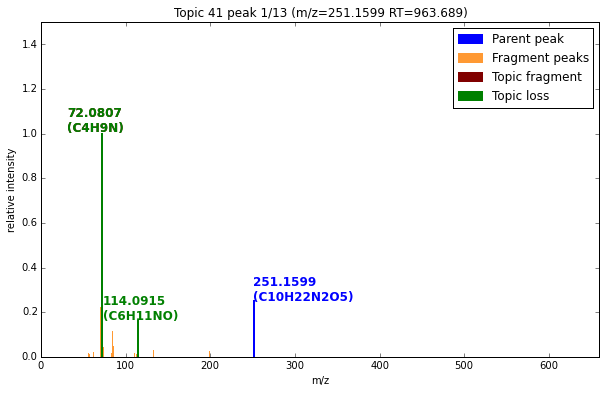

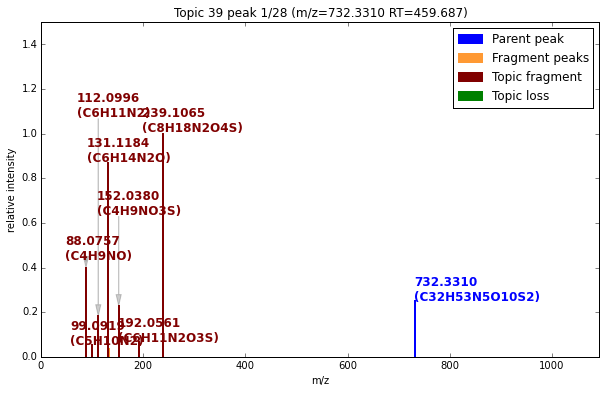

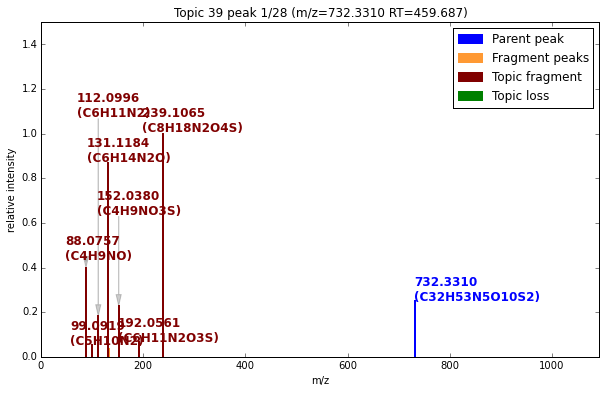

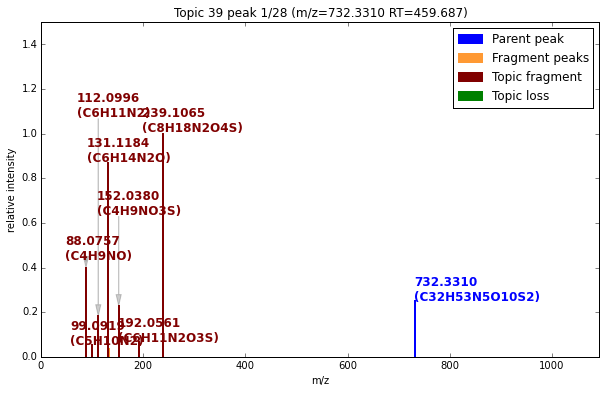

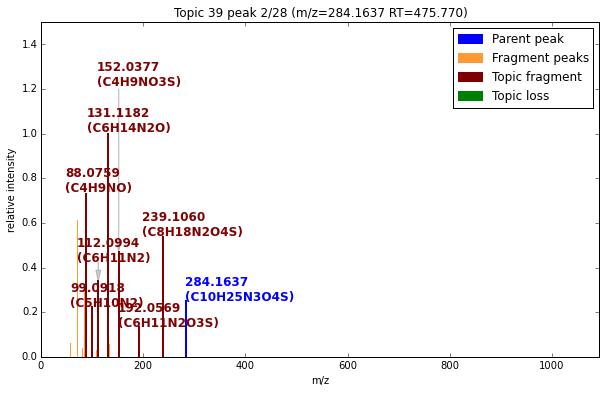

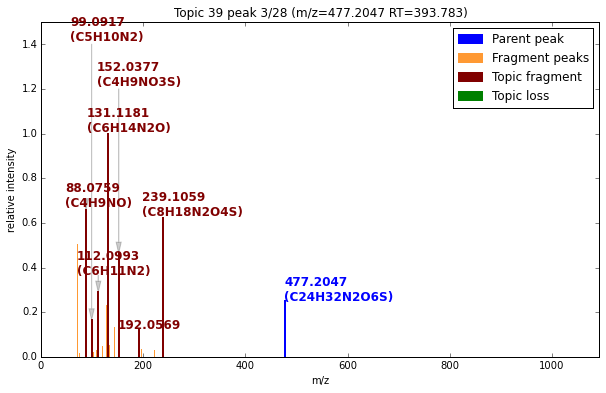

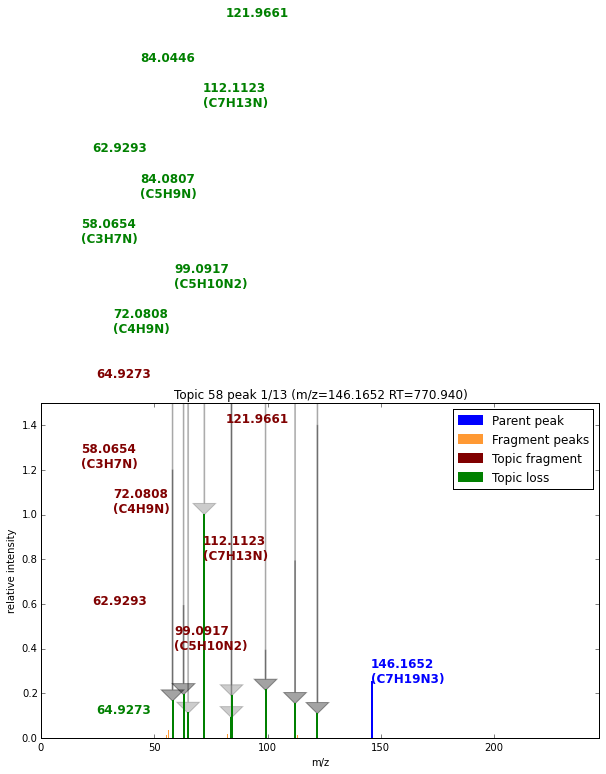

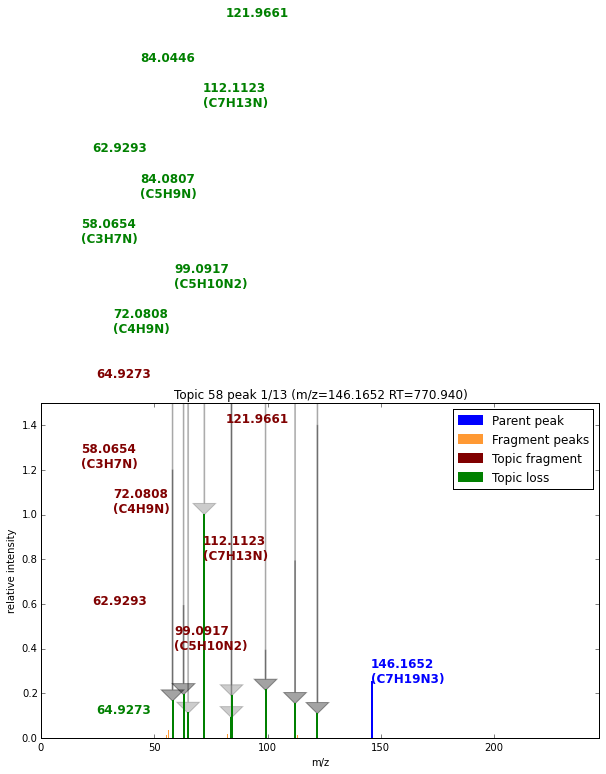

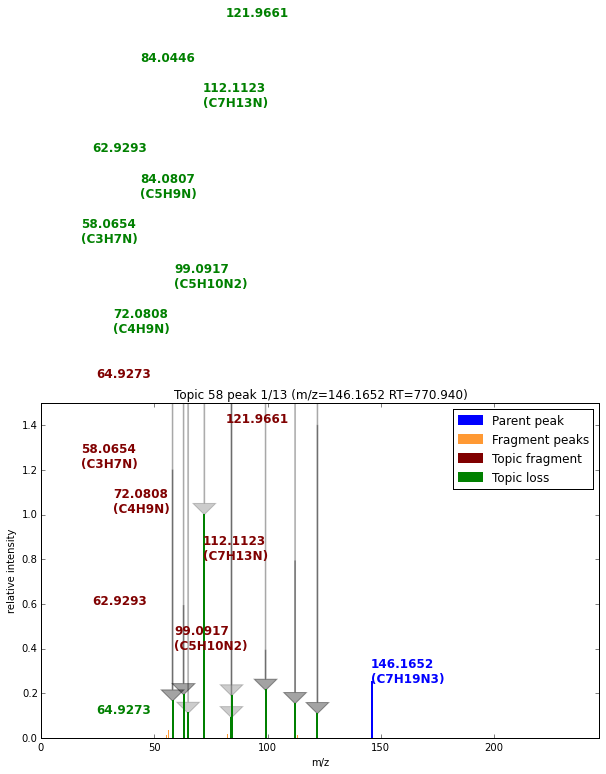

KeyboardInterrupt: 

In [11]:
interactive=True
consistency=0.0
special_nodes = None
ms2lda.plot_lda_fragments(consistency=consistency, interactive=interactive, to_highlight=special_nodes)